In [1]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
from shapely.geometry import LineString, Point

In [2]:
def load_data(cycle_route_fp, buildings_fp, target_crs=28992):
    routes = gpd.read_file(cycle_route_fp)
    buildings = gpd.read_file(buildings_fp)
    
    routes = routes[~routes.geometry.is_empty]
    buildings = buildings[~buildings.geometry.is_empty]
    
    routes = routes.to_crs(epsg=target_crs)
    buildings = buildings.to_crs(epsg=target_crs)
    
    return routes, buildings

def buffer_routes(routes, distance_m=100):
    return routes.geometry.buffer(distance_m)

def buildings_near_routes(building_points, routes_buffer):
    buffer_gdf = gpd.GeoDataFrame(geometry=routes_buffer, crs=building_points.crs)

    joined = gpd.sjoin(
        building_points,
        buffer_gdf,
        how="inner",
        predicate="intersects"
    )

    near_count = joined.shape[0]
    total_count = building_points.shape[0]

    pct_near = (near_count / total_count) * 100
    return pct_near

def nearest_route_distance(building_points, routes):
    # Unary union for speed
    routes_union = routes.geometry.unary_union

    building_points["nearest_route_m"] = building_points.geometry.distance(routes_union)
    return building_points

def route_density(routes, area_polygon):
    total_length_km = routes.length.sum() / 1000
    area_km2 = area_polygon.area / 1e6

    return total_length_km / area_km2

def analyze_study_area(routes, building_points):
    # Buffer-based accessibility
    buffer_100m = buffer_routes(routes, distance_m=100)
    pct_buildings_near = buildings_near_routes(building_points, buffer_100m)

    # Nearest distance
    building_points = nearest_route_distance(building_points, routes)
    avg_distance = building_points["nearest_route_m"].mean()

    # Route density
    study_area = building_points.unary_union.convex_hull
    density = route_density(routes, study_area)

    return {
        "pct_buildings_near_route": pct_buildings_near,
        "avg_distance_to_route_m": avg_distance,
        "route_density_km_per_km2": density
    }

def plot_building_proximity(building_points):
    fig, ax = plt.subplots(figsize=(10, 10))
    building_points.plot(
        column="nearest_route_m",
        cmap="viridis",
        legend=True,
        markersize=3,
        ax=ax
    )
    ax.set_title("Distance of Buildings to Nearest Cycling Route (m)")
    ax.axis("off")
    plt.show()
    
def plot_pairwise_density_vs_distance(metrics):
    x = metrics["route_density_km_per_km2"]
    y = metrics["avg_distance_to_route_m"]

    plt.figure(figsize=(6, 6))
    plt.scatter(x, y)
    plt.xlabel("Cycling Route Density (km / km²)")
    plt.ylabel("Average Distance to Nearest Route (m)")
    plt.title("Route Density vs. Accessibility")
    plt.grid(True)
    plt.show()


def plot_summary_bar(metrics):
    df = pd.DataFrame.from_dict(metrics, orient="index", columns=["Value"])
    df.plot(kind="bar", legend=False, figsize=(8, 5))
    plt.title("Cycling-Friendliness Metrics")
    plt.ylabel("Value")
    plt.xticks(rotation=45, ha="right")
    plt.show()
    
def test_buffer_routes():
    """Buffering a line should return polygon geometries."""
    test_line = gpd.GeoDataFrame(
        geometry=[LineString([(0, 0), (0, 10)])],
        crs="EPSG:28992"
    )
    buf = buffer_routes(test_line, distance_m=10)
    assert all(g.geom_type == "Polygon" for g in buf), "Buffer did not return polygons"
    print("✓ test_buffer_routes passed")


def test_buildings_near_routes_basic():
    """Buildings inside buffer should be counted correctly."""
    buildings = gpd.GeoDataFrame(
        geometry=[Point(0, 0), Point(100, 100)],
        crs="EPSG:28992"
    )
    routes = gpd.GeoDataFrame(
        geometry=[LineString([(-10, 0), (10, 0)])],
        crs="EPSG:28992"
    )

    buffer = buffer_routes(routes, distance_m=20)
    pct = buildings_near_routes(buildings, buffer)

    assert abs(pct - 50.0) < 1e-6, "Incorrect percentage of buildings near routes"
    print("✓ test_buildings_near_routes_basic passed")


def test_nearest_route_distance():
    """Distance to nearest route should be geometrically correct."""
    buildings = gpd.GeoDataFrame(
        geometry=[Point(0, 0)],
        crs="EPSG:28992"
    )
    routes = gpd.GeoDataFrame(
        geometry=[LineString([(0, 10), (10, 10)])],
        crs="EPSG:28992"
    )

    result = nearest_route_distance(buildings, routes)
    assert abs(result["nearest_route_m"].iloc[0] - 10) < 1e-6, "Nearest distance incorrect"
    print("✓ test_nearest_route_distance passed")


def test_route_density_simple_case():
    """Route density should match manual calculation."""
    routes = gpd.GeoDataFrame(
        geometry=[LineString([(0, 0), (0, 1000)])],  # 1 km route
        crs="EPSG:28992"
    )
    area_polygon = Point(0, 0).buffer(1000)  # ~3.14 km² (circle)

    density = route_density(routes, area_polygon)
    expected = 1 / (area_polygon.area / 1e6)

    assert abs(density - expected) < 1e-6, "Route density calculation incorrect"
    print("✓ test_route_density_simple_case passed")


def test_analyze_study_area_outputs():
    """Analyze function should return all required metrics."""
    routes = gpd.GeoDataFrame(
        geometry=[LineString([(0, 0), (0, 100)])],
        crs="EPSG:28992"
    )
    buildings = gpd.GeoDataFrame(
        geometry=[Point(10, 0), Point(200, 0)],
        crs="EPSG:28992"
    )

    metrics = analyze_study_area(routes, buildings)

    required_keys = {
        "pct_buildings_near_route",
        "avg_distance_to_route_m",
        "route_density_km_per_km2"
    }

    assert required_keys.issubset(metrics.keys()), "Missing metrics in analysis output"
    print("✓ test_analyze_study_area_outputs passed")


def test_empty_buildings_handling():
    """Empty building input should raise a meaningful error or return NaNs."""
    routes = gpd.GeoDataFrame(
        geometry=[LineString([(0, 0), (0, 100)])],
        crs="EPSG:28992"
    )
    buildings = gpd.GeoDataFrame(geometry=[], crs="EPSG:28992")

    try:
        analyze_study_area(routes, buildings)
        print("✓ test_empty_buildings_handling passed")
    except Exception:
        print("✓ test_empty_buildings_handling passed (exception raised as expected)")


pct_buildings_near_route     85.470232
avg_distance_to_route_m     164.665459
route_density_km_per_km2     11.217377
dtype: float64


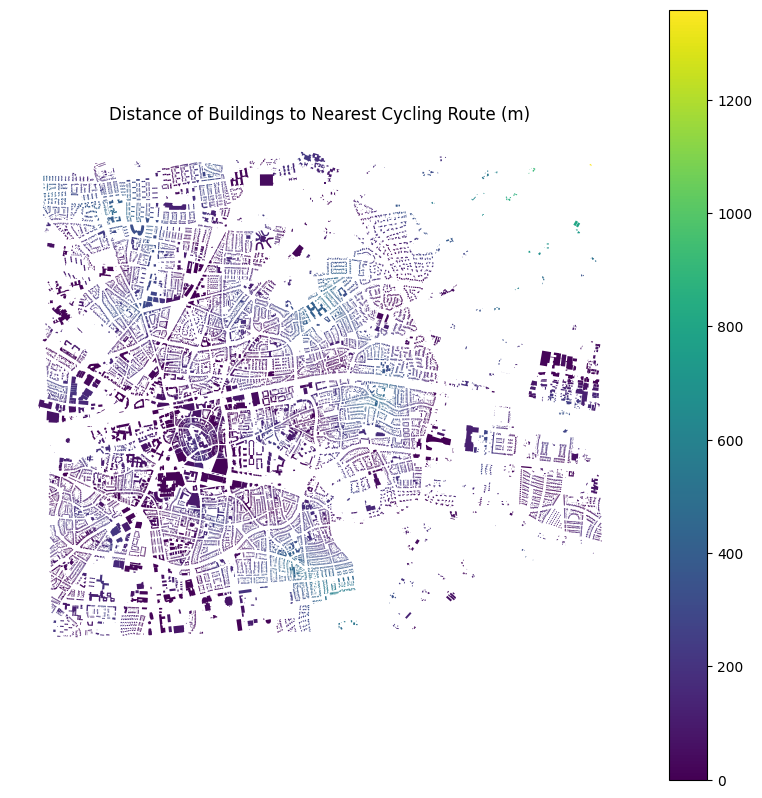

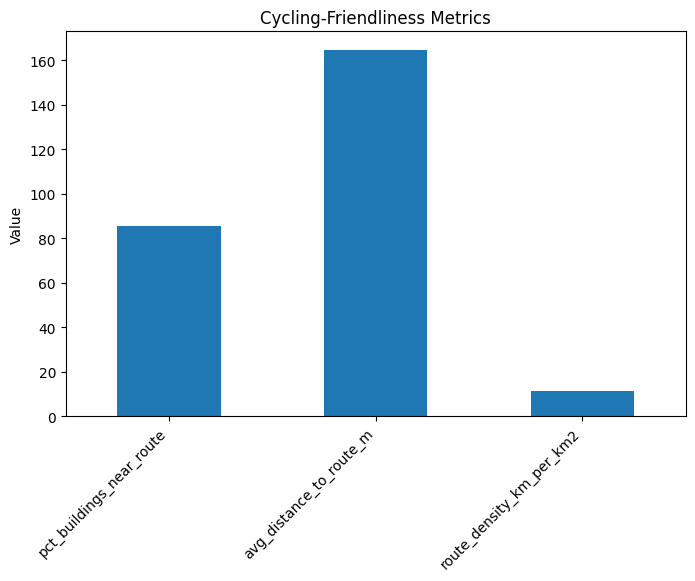

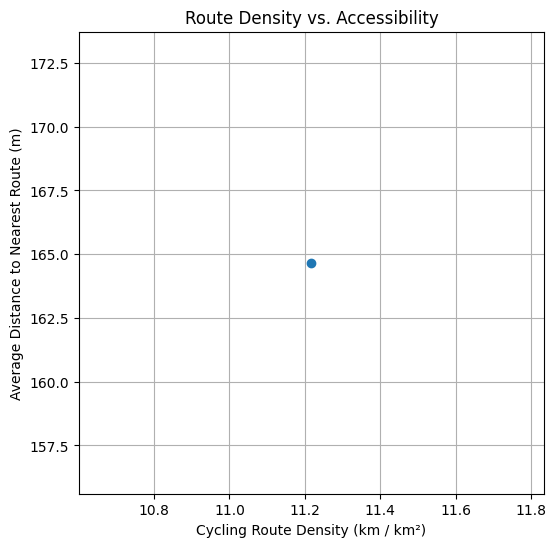

✓ test_buffer_routes passed
✓ test_buildings_near_routes_basic passed
✓ test_nearest_route_distance passed
✓ test_route_density_simple_case passed
✓ test_analyze_study_area_outputs passed
✓ test_empty_buildings_handling passed (exception raised as expected)


/tmp/ipykernel_120/1166872906.py:43: RuntimeWarning: divide by zero encountered in double_scalars
  return total_length_km / area_km2


In [4]:
if __name__ == "__main__":

    # ---- File paths ----
    cycle_routes_fp = "enschede_road_network.gpkg"
    buildings_fp = "enschede_buildings.gpkg"

    # ---- Load & prepare ----
    routes, buildings = load_data(cycle_routes_fp, buildings_fp)
    building_points = buildings

    # ---- Analysis ----
    metrics = analyze_study_area(routes, building_points)
    print(pd.Series(metrics))

    # ---- Visuals ----
    plot_building_proximity(building_points)
    plot_summary_bar(metrics)
    plot_pairwise_density_vs_distance(metrics)
    
    # ---- Tests ----
    test_buffer_routes()
    test_buildings_near_routes_basic()
    test_nearest_route_distance()
    test_route_density_simple_case()
    test_analyze_study_area_outputs()
    test_empty_buildings_handling()

In [3]:
def analyze_by_admin_region(routes, building_points, admin_gdf, buffer_dist=100):
    results = []

    for _, region in admin_gdf.iterrows():
        region_geom = region.geometry

        # Clip datasets
        region_routes = gpd.clip(routes, region_geom)
        region_buildings = building_points[building_points.within(region_geom)]

        if region_routes.empty or region_buildings.empty:
            continue

        # % buildings near routes
        buffer = buffer_routes(region_routes, buffer_dist)
        pct_near = buildings_near_routes(region_buildings, buffer)

        # Average distance
        region_buildings = nearest_route_distance(region_buildings, region_routes)
        avg_dist = region_buildings["nearest_route_m"].mean()

        # Route density
        length_km = region_routes.length.sum() / 1000
        area_km2 = region_geom.area / 1e6
        density = length_km / area_km2

        results.append({
            "region_name": region["name"], 
            "pct_buildings_near_route": pct_near,
            "avg_distance_to_route_m": avg_dist,
            "route_density_km_per_km2": density
        })

    return pd.DataFrame(results)

def join_metrics_to_regions(admin_gdf, results_df):
    return admin_gdf.merge(
        results_df,
        left_on="name", 
        right_on="region_name",
        how="left"
    )

def plot_admin_choropleth(admin_gdf, metric, title):
    fig, ax = plt.subplots(figsize=(10, 10))
    admin_gdf.plot(
        column=metric,
        cmap="Greens",
        legend=True,
        edgecolor="black",
        linewidth=0.3,
        ax=ax
    )
    ax.set_title(title, fontsize=14)
    ax.axis("off")
    plt.show()

In [ ]:
# ---- Administrative analysis ----
admin_gdf = admin_gdf.to_crs(epsg=28992)

results_admin = analyze_by_admin_region(
    routes,
    building_points,
    admin_gdf
)

admin_with_metrics = join_metrics_to_regions(admin_gdf, results_admin)

# ---- Choropleth ----
plot_admin_choropleth(
    admin_with_metrics,
    metric="route_density_km_per_km2",
    title="Cycling Route Density per Administrative Region (km/km²)"
)

In [ ]:
#region level pairwise scatter
plt.scatter(
    results_admin["route_density_km_per_km2"],
    results_admin["avg_distance_to_route_m"]
)
plt.xlabel("Route Density (km/km²)")
plt.ylabel("Avg Distance to Route (m)")
plt.title("Route Density vs Accessibility by Region")
plt.show()